In [22]:
from networks_cnn import SteerableCNN
from escnn2.r2convolution import R2Conv
import torch
import matplotlib.pyplot as plt
import time
import numpy as np
import escnn.nn as nn
from torch.nn.functional import interpolate

In [2]:
DEVICE = 'cuda'

In [3]:
network = SteerableCNN(mnist_type="double", basisexpansion="learn_eq_norm")
print(network.network_name)



Learnable O2SteerableCNN


In [4]:
network = network.to(DEVICE)

In [39]:
def log_equivariance_error(model, epoch, config, loader):
    model.eval()
    layers = list(filter(lambda x: isinstance(x, R2Conv), model.modules()))
    if not layers:
        return
    layer_ids = [layer.layer_id for layer in layers]
    layer_offset = min(layer_ids)
    eq_modules = [[layer for layer in module] if isinstance(module, nn.SequentialModule) else [module] for module in model.eq_layers]
    eq_modules = [module for sublist in eq_modules for module in sublist]
    group = model.act_r2.fibergroup
    if group.continuous:
        n = 20
    else:
        try:
            n = group.rotation_order
        except:
            n = group.N
    testing_elements = [elem for elem in group.testing_elements(n=n)]
    factor = len(testing_elements) / n
    g_elements = torch.linspace(0, 2 * torch.pi * factor, len(testing_elements))
    # x, _ = next(iter(loader))
    x = torch.randn(10, 1, 56, 56)
    with torch.no_grad():
        for layer in eq_modules:
            in_type = layer.in_type
            x = in_type(x).to(DEVICE)
            preds = layer(x)
            x_shape = list(x.shape)[2:]
            x = in_type(interpolate(x.tensor, size=(32, 32), mode='bilinear', align_corners=True))
            if isinstance(layer, R2Conv):
                layer_id = layer.layer_id
                
                out_type = layer.out_type
                # print(out_type)
                start_channel = 0
                # preds_norm = torch.empty_like(preds.tensor)
                # for channel in out_type:
                #     channel_norm = torch.linalg.norm(preds.tensor[:, start_channel: start_channel + channel.size, :, :], axis=1, keepdim=True)
                #     preds_norm[:, start_channel:start_channel + channel.size, :, :] = channel_norm + 1e-4
                #     start_channel += channel.size
                # print(torch.linalg.norm(preds.tensor, axis=1, keepdim=True))
                # print(preds.shape, preds_norm.shape)
                errors = []
                for t in testing_elements:
                    start = time.time()
                    augmentend_data = x.transform(t)
                    augmentend_data = in_type(interpolate(augmentend_data.tensor, size=x_shape, mode='bilinear', align_corners=True))
                    aug_preds = layer(augmentend_data).tensor

                    channel_errors = []
                    start_channel = 0
                    preds_transform = preds.transform(t).tensor
                    for channel in out_type:
                        aug_preds_channel = aug_preds[:, start_channel: start_channel + channel.size, :, :]
                        preds_transform_channel = preds_transform[:, start_channel: start_channel + channel.size, :, :]
                        # preds_norm_channel = preds_norm[:, start_channel:start_channel + channel.size, :, :]
                        channel_errors.append((torch.linalg.norm(aug_preds_channel - preds_transform_channel, axis=1, keepdim=True)).mean().cpu().numpy())
                    print(time.time() - start)
                    # error = (
                    #     torch.linalg.norm(aug_preds - preds.transform(t).tensor, axis=1)
                    #     / preds_norm
                    # ).mean()
                    # print('2')
                    # print(errors)
                    error = np.mean(channel_errors)

                    errors.append(error.item())
                    # print(time.time() - start)
                    # print(error)
                data = [
                    [g_element, error, layer_id, config]
                    for (g_element, error) in zip(g_elements, errors)
                ]
            

                    # table = wandb.Table(
                    #     data=data,
                    #     columns=[
                    #         "transformation element",
                    #         "error",
                    #         "layer_id",
                    #         "run_name",
                    #     ],
                    # )

                    # wandb.log(
                    #     {
                    #         f"Equivariance error layer {layer_id - layer_offset}": wandb.plot.line(
                    #             table,
                    #             "transformation element",
                    #             "error",
                    #             title=f"Equivariance error layer {layer_id - layer_offset}",
                    #         )
                    #     },
                    #     step=epoch,
                    # )

                plt.title(f"Equivariance error {layer_id - layer_offset}")

                plt.plot(g_elements, errors)
                plt.ylim([0, 1.1 * max(errors) + 1e-4])
                plt.ylabel("Equivariance Error")
                plt.xlabel("Groupelement g")
                # wandb.log(
                #     {
                #         f"gradual Equivariance error {layer_id - layer_offset}": wandb.Image(
                #             plt
                #         )
                #     },
                #     step=epoch,
                # )
                plt.show()
                plt.close()
            x = preds.tensor
    model.train()

In [40]:
# optimizer = torch.optim.Adam(network.parameters())
# x = torch.randn(128, 1, 56, 56).to(DEVICE)
# preds = network(x)
# torch.mean(preds).backward()
# optimizer.step()
# preds2 = network(x)
# print(preds - preds2)

0.016135215759277344
1.1982581615447998
1.1514348983764648
1.1778242588043213
1.1963412761688232
0.01710820198059082
1.1799657344818115
1.1217544078826904
1.1518349647521973
1.1919968128204346
0.021464824676513672
1.2081520557403564
1.1549782752990723
1.1671850681304932
1.2243847846984863
0.019667863845825195
1.2018542289733887
1.1497840881347656
1.129774570465088
1.1856255531311035
0.02666497230529785
1.174645185470581
1.1456868648529053
1.13169527053833
1.2504668235778809
0.015900850296020508
1.2186472415924072
1.1260652542114258
1.1338422298431396
1.1910691261291504
0.018455982208251953
1.247180700302124
1.1693611145019531
1.1327874660491943
1.2093095779418945
0.018117189407348633
1.2629921436309814
1.1369409561157227
1.1305646896362305
1.183072566986084


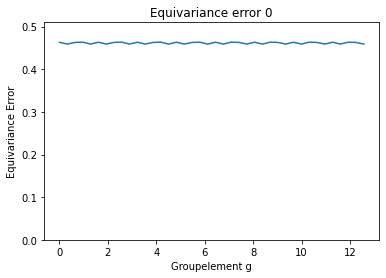

0.0432429313659668
2.7257163524627686
2.5236141681671143
2.5507314205169678
2.623227119445801
0.05635213851928711
2.674654960632324
2.5344314575195312
2.6153953075408936
2.671762228012085
0.043120384216308594
2.8104305267333984
2.5787606239318848
2.593832492828369
2.7408649921417236
0.050096988677978516
2.7071022987365723
2.5441744327545166
2.544954776763916
2.6735193729400635
0.046471357345581055
2.721259355545044
2.5013153553009033
2.5210797786712646
2.6365818977355957
0.048125267028808594
2.7522878646850586
2.505276918411255
3.130770444869995
3.270087242126465
0.0452115535736084
2.7615513801574707
2.5720536708831787
2.551126480102539
2.650029182434082
0.05668234825134277
2.655311346054077
2.6228458881378174
2.499600887298584
2.6642279624938965


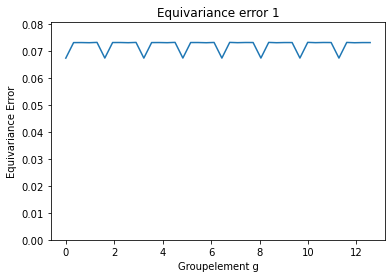

0.03641033172607422
0.9801657199859619
0.9082646369934082
0.8911020755767822
0.940345287322998
0.03497791290283203
0.9861259460449219
0.9000754356384277
1.0060434341430664
0.9771366119384766
0.035137176513671875
0.9896450042724609
0.955547571182251
0.9335000514984131
0.9455995559692383
0.027585268020629883
1.025423288345337
0.9020307064056396
0.8785090446472168
0.9513566493988037
0.03109884262084961
0.9915680885314941
0.8812522888183594
0.8578317165374756
0.915032148361206
0.025840282440185547
0.9790389537811279
0.9121575355529785
0.9519953727722168
1.000821590423584
0.02803492546081543
0.9809703826904297
0.9322414398193359
0.9045534133911133
0.9604690074920654
0.026378631591796875
1.0250849723815918
0.8904047012329102
0.8922364711761475
0.9355545043945312


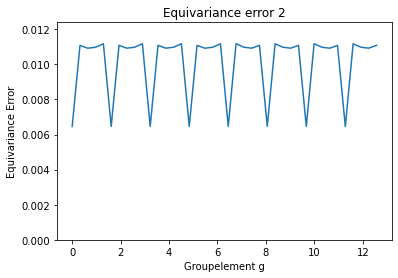

0.046517372131347656
1.074902057647705
1.0743014812469482
1.0982732772827148
1.137897253036499
0.0414278507232666
1.1684939861297607
1.0722923278808594
1.091590166091919
1.164060354232788
0.039177656173706055
1.119323968887329
1.0501160621643066
1.0562808513641357
1.0844311714172363
0.044052839279174805
1.090813159942627
1.0682806968688965
1.0570931434631348
1.1304821968078613
0.04862570762634277
1.1179311275482178
1.0137803554534912
1.0518579483032227
1.0805909633636475
0.03717207908630371
1.1420044898986816
1.0853972434997559
1.186434268951416
1.2060496807098389
0.046721458435058594
1.1206777095794678
1.1036100387573242
1.0857923030853271
1.173290491104126
0.04792928695678711
1.1015396118164062
1.0504400730133057
1.02498197555542
1.0828168392181396


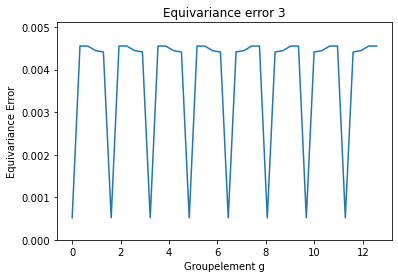

0.0497593879699707
1.5712158679962158
1.5042078495025635
1.517073392868042
1.5724620819091797
0.04950404167175293
1.5948824882507324
1.5296623706817627
1.5271341800689697
1.6019957065582275
0.04564952850341797
1.5830321311950684
1.513890027999878
1.5081610679626465
1.5787432193756104
0.04744744300842285
1.57021164894104
1.4942052364349365
1.5445542335510254
1.610189437866211
0.05561494827270508
1.6071598529815674
1.5193870067596436
1.5254249572753906
1.6050388813018799
0.047258615493774414
1.6237576007843018
1.5105302333831787
1.569514274597168
1.6266353130340576
0.05012822151184082


KeyboardInterrupt: 

In [41]:
log_equivariance_error(network, 0, 'kip', 0)

In [19]:
log_equivariance_error(network, 0, 'kip', 0)

0.018108129501342773
0.022004127502441406
0.022984981536865234
0.01811385154724121
0.04652905464172363
0.04851651191711426
0.04322648048400879
0.05776834487915039
0.03326988220214844
0.03675079345703125
0.028665542602539062
0.03231406211853027
0.04068160057067871
0.041771650314331055
0.0366060733795166
0.03505706787109375
0.037317752838134766
0.04090261459350586
0.04013395309448242
0.04134798049926758
0.029927492141723633
0.024624109268188477
0.03186774253845215
0.029497623443603516


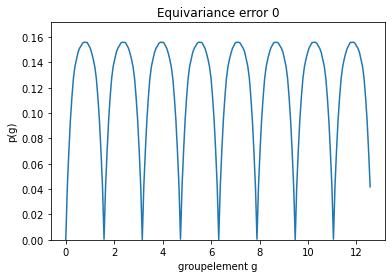

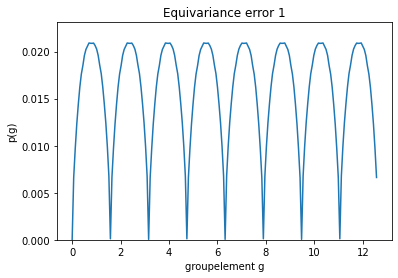

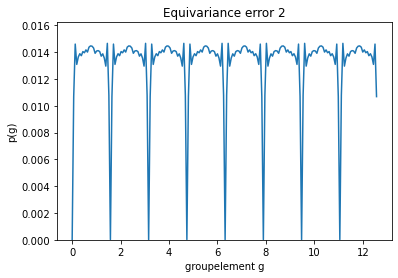

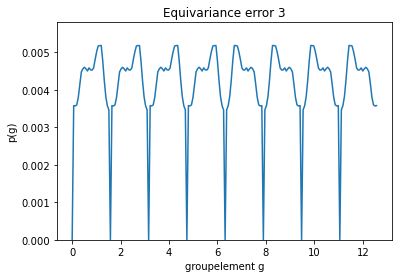

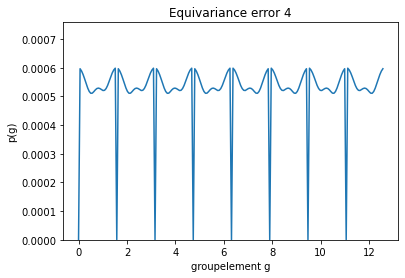

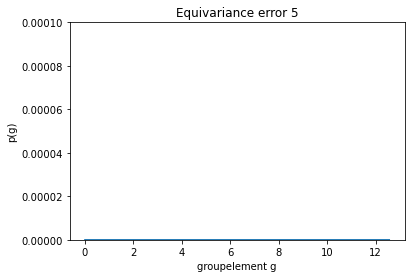

In [47]:
log_equivariance_error(network, 0, 'kip', 0)